# Evolutionary Strategies

In order to understand how we'll be evolving the FPGA to approximate any function, let's start of with a simple problem. We will try to evolve random bit strings to approximate the phrase "`Hello, World!`". We will encode "`Hello, World!`" into a stream of binary 7-bit ASCII strings. 

### Table of Contents
1. [Simple Genetic Algo](#sga)

In [1]:
# Standard Libraries
import operator, random
from tqdm import tqdm

# Visualization / ML Libraries
from collections import namedtuple
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import seaborn as sns
from sklearn.datasets import make_spd_matrix

# plotting defaults
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)
get_colors = lambda length: plt.get_cmap('Spectral')(np.linspace(0, 1.0, length))

np.random.seed(seed=100)

In [2]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = (18, 12)

### Helper functions

In [3]:
# Return a random binary list of length N
# drawn from uniform distribution
random_bits = lambda N: np.random.choice([0, 1], size=(N,), p=[0.5, 0.5])

# Converts text to bit string
def text_to_bits(text, encoding='utf-8', errors='surrogatepass'):
    bits = bin(int.from_bytes(text.encode(encoding, errors), 'big'))[2:]
    return bits.zfill(8 * ((len(bits) + 7) // 8))

# Converts bit string to normal text
def text_from_bits(bits, encoding='utf-8', errors='surrogatepass'):
    n = int(bits, 2)
    return n.to_bytes((n.bit_length() + 7) // 8, 'big').decode(encoding, errors) or '\0'

In [4]:
text_from_bits(text_to_bits('Hello, World!'))

'Hello, World!'

---
## Simple Genetic Algorithm<a id='sga'></a>

Pseudo-code of Evolutionary Strategy:

Step One: Generate the initial population of individuals randomly. (First generation)

Step Two: Evaluate the fitness of each individual in that population (time limit, sufficient fitness achieved, etc.)

Step Three: Repeat the following regenerational steps until termination:
- Select the best-fit individuals for reproduction. (Parents)
    1. Breed new individuals through crossover and mutation operations to give birth to offspring.
    2. Evaluate the individual fitness of new individuals.
    3. Replace least-fit population with new individuals.

Get Target word's bit-string representation

In [5]:
target_word = 'Hello, World!'
target_word_bits = [int(bit) for bit in text_to_bits(target_word)]

### 1. Create Population: Generate Random Individuals

In [6]:
pop_size = 100
population = [[bit for bit in random_bits(len(target_word_bits))] for _ in range(pop_size)]

Since our population is represented as a matrix, it might be possible to use matrix operations to compute the fitness of each individual (row of matrix).

### 2. Get Fitness of individiuals

Let's define a fitness function. Because we'll be evaluating how much a bit-string matches another bit-string, we'll use the cosine similarity as a measure of fitness:

$$
\begin{aligned}
cos(\theta) &= \frac{\vec{\mathbf{a}} \cdot \vec{\mathbf{b}}}{\vert\vert\vec{\mathbf{a}}\vert\vert\cdot\vert\vert\vec{\mathbf{b}}\vert\vert}, -1 \leq cos(\theta) \leq 1
\end{aligned}
$$

In [7]:
def fitness(individual, target_word_bits=target_word_bits):
    '''
    Function:
    ---------
    Determines the fitness of an individual based
    on cosine similarity to bit-string
    
    Parameters:
    -----------
    individual: (list) List of 0s and 1s
    target_word_bits: (list) list of 0s and 1s representing the target word 
    
    Returns:
    --------
    fitness score (cosine similarity) of the inidividual
    '''
    
    # Function to calculate cosine similarity
    # between 2 vectors
    cos_similarity = lambda a, b: np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    
    return cos_similarity(individual, target_word_bits)

### 3. Select Mating Pool

In [8]:
def select_mating_pool(population, 
                       target_word_bits=target_word_bits, 
                       elite_proportion=0.2, 
                       selection_method='fitness-proportionate'):
    '''
    Function:
    ---------
    Generates new mating pool for next generation of evolution
    using a combination of elite individuals from current population
    and selecting individuals based on selection method specified
    
    Parameters:
    -----------
    population: (list) List of [0, 1, 1, 0, ...] specifying an individual
    target_word_bits: (list) List of [0, 1, 1, 0, ...] specifying the target word to be approximated
    elite_proportion: Proportion of current population we want to preserve to mate as the elite
    selection_method: The selection method to choose which individuals to mate
        - Choose from:
            1. fitness-proportionate
            2. truncation
            3. tournament
            4. stochastic-universal-sampling
            5. reward-based
    
    Returns:
    --------
    A list of the new mating pool to be used for the next stage 
    of the simple genetic algorithm, breeding and average fitness score
    of the population
    '''
    
    # ========= Local Scope Variables =========
    
    # Final mating pool
    mating_pool = []
    
    # Named tuple of Individuals
    Individual = namedtuple('Individual', ['value', 'fitness_score'])
    
    # ========= Selection Functions =========
    
    def fitness_proportionate_selection(population_sorted_by_fitness, num_to_select):
        '''
        Function:
        ---------
        Selects individuals from population using the fitness proportionate selection
        algorithm. Higher probability of selection is given to individuals with
        a higher normalized fitness score, where normalized fitness score sum to 
        1.0
        
        Parameters:
        -----------
        population_sorted_by_fitness: (list: Individual(value=[0, 1, 0, 1, 1, ...], fitness_score))
        num_to_select: (int) Number of individuals to be selected to add into mating pool
        
        Returns:
        --------
        List of Individual's value list - [[0, 1, 0, 1, 1, ...], [0, 1, 0, 1, 1, ...], ...]
        '''
        
        # The selected individuals to mate in
        # the next generation
        selected_individuals = []
        
        # 1. The fitness function is evaluated for each 
        # individual, providing fitness values, which are 
        # then normalized. Normalization means dividing the 
        # fitness value of each individual by the sum of all 
        # fitness values, so that the sum of all resulting 
        # fitness values equals 1.
        values, fitness_scores = list(zip(*population_sorted_by_fitness))
        normalized_fitness_scores = fitness_scores / np.sum(fitness_scores)

        # 2. The population is sorted by ASCENDING fitness 
        # values.
        population_sorted_by_normalized_fitness_scores = \
            sorted(list(zip(values, normalized_fitness_scores)), key=operator.itemgetter(1), reverse=False)

        # 3. Accumulated normalized fitness values are computed: 
        # the accumulated fitness value of an individual is the 
        # sum of its own fitness value plus the fitness values 
        # of all the previous individuals; the accumulated 
        # fitness of the last individual should be 1, otherwise 
        # something went wrong in the normalization step.
        values, normalized_fitness_scores = list(zip(*population_sorted_by_normalized_fitness_scores))
        population_sorted_by_cum_normalized_fitness_scores = \
            [Individual(value=value, fitness_score=normalized_fitness_score) for value, normalized_fitness_score in list(zip(values, np.cumsum(normalized_fitness_scores)))]
        
        while len(selected_individuals) < num_to_select:

            # 4. A random number R between 0 and 1 is chosen. 
            # (Uniform distribution)
            R = np.random.random(1)[0]
            
            # 5. The selected individual is the last one whose 
            # accumulated normalized value is greater than or 
            # equal to R. Intuitively, we want the individuals 
            # with the greatest fitness to have a higher probability 
            # of being chosen
            
            # We set the last individual as the selected one
            # as it has the highest fitness score. However, 
            # let's find the smallest fitness score individual
            # that is > R
            selected_individual = population_sorted_by_cum_normalized_fitness_scores[-1]
            
            # Jeff: We'll use a modified version of 
            # binary search here to find the lowest fitness score
            # of individual that is greater than R
            # O(log(N))
            left_idx, right_idx = 0, len(population_sorted_by_cum_normalized_fitness_scores) - 1
            while left_idx < right_idx:
                
                mid_idx = (right_idx + left_idx) // 2
                
                # Case 1: R is on right side of list
                if population_sorted_by_cum_normalized_fitness_scores[mid_idx].fitness_score < R:
                    
                    left_idx = mid_idx + 1
                    
                # Case 2: R is on left side of list
                elif population_sorted_by_cum_normalized_fitness_scores[mid_idx].fitness_score > R:
                    
                    # Doing this keeps track of the last individual that 
                    # has a higher fitness score than R
                    selected_individual = population_sorted_by_cum_normalized_fitness_scores[mid_idx]
                    right_idx = mid_idx - 1
                
                # Case 3: R is this
                else:
                    selected_individual = population_sorted_by_cum_normalized_fitness_scores[mid_idx]
    
            # Add selected individual to the mating pool
            selected_individuals.append(selected_individual) 
        
        return [individual.value for individual in selected_individuals]
    
    def truncation_selection(population_sorted_by_fitness, num_to_select):
        '''
        Function:
        ---------
        Candidate solutions are ordered by fitness, and 
        some proportion, p, (e.g. p = 1/2, 1/3, etc.), of 
        the fittest individuals are selected and reproduced 1/p times.
        
        Parameters:
        -----------
        population_sorted_by_fitness: (list: Individual(value=[0, 1, 0, 1, 1, ...], fitness_score))
        num_to_select: (int) Number of individuals to be selected to add into mating pool
        
        Returns:
        --------
        List of Individual's value list - [[0, 1, 0, 1, 1, ...], [0, 1, 0, 1, 1, ...], ...]
        '''
        return None
    
    def tournament_selection():
        '''
        Function:
        ---------
        choose k (the tournament size) individuals from the population at random
        choose the best individual from the tournament with probability p
        choose the second best individual with probability p*(1-p)
        choose the third best individual with probability p*((1-p)^2)
        and so on
        
        Parameters:
        -----------
        population_sorted_by_fitness: (list: Individual(value=[0, 1, 0, 1, 1, ...], fitness_score))
        num_to_select: (int) Number of individuals to be selected to add into mating pool
        
        Returns:
        --------
        List of Individual's value list - [[0, 1, 0, 1, 1, ...], [0, 1, 0, 1, 1, ...], ...]
        '''
        return None
    
    def stochastic_universal_sampling_selection():
        '''
        Function:
        ---------
        SUS is a development of fitness proportionate selection (FPS) 
        which exhibits no bias and minimal spread. Where FPS chooses 
        several solutions from the population by repeated random sampling, 
        SUS uses a single random value to sample all of the solutions by 
        choosing them at evenly spaced intervals. This gives weaker members 
        of the population (according to their fitness) a chance to be chosen.
        
        Parameters:
        -----------
        population_sorted_by_fitness: (list: Individual(value=[0, 1, 0, 1, 1, ...], fitness_score))
        num_to_select: (int) Number of individuals to be selected to add into mating pool
        
        Returns:
        --------
        List of Individual's value list - [[0, 1, 0, 1, 1, ...], [0, 1, 0, 1, 1, ...], ...]
        '''
        return None
    
    def reward_based_selection():
        '''
        Function:
        ---------
        Candidate solutions are ordered by fitness, and 
        some proportion, p, (e.g. p = 1/2, 1/3, etc.), of 
        the fittest individuals are selected and reproduced 1/p times.
        
        Parameters:
        -----------
        population_sorted_by_fitness: (list: Individual(value=[0, 1, 0, 1, 1, ...], fitness_score))
        num_to_select: (int) Number of individuals to be selected to add into mating pool
        
        Returns:
        --------
        List of Individual's value list - [[0, 1, 0, 1, 1, ...], [0, 1, 0, 1, 1, ...], ...]
        '''
        return None
    
    # ========= Mating Pool Generation Procedure =========
    
    # 1. Get sorted list of individuals in population
    # by cosine similarity with target_word_bits
    # (fittest individuals at start of the list)
    population_sorted_by_fitness = \
        sorted([Individual(value=value, fitness_score=fitness(value)) for value in population], 
               key=operator.itemgetter(1), 
               reverse=True)
    
    # Average fitness score of population
    avg_fitness_score = np.mean(list(zip(*population_sorted_by_fitness))[1])
    
    # 2. Enforce elitism by copying a number
    # of the fittest individuals to the mating pool
    # and select the rest to fill the population
    # using the selection methods below
    elite_size = int(elite_proportion * len(population_sorted_by_fitness))
    mating_pool += \
        [individual.value for individual in population_sorted_by_fitness[:elite_size]]
    
    # 3. Choose method to select the individuals
    # to fill up the rest of the non-elite 
    # mating pool
    non_elite_size = len(population_sorted_by_fitness) - elite_size
    
    if selection_method == 'fitness-proportionate':
        return (mating_pool + fitness_proportionate_selection(population_sorted_by_fitness, num_to_select=non_elite_size), avg_fitness_score)
    elif selection_method == 'truncation':
        return (mating_pool + truncation_selection(), avg_fitness_score)
    elif selection_method == 'tournament':
        return (mating_pool + tournament_selection(), avg_fitness_score)
    elif selection_method == 'stochastic-universal-sampling':
        return (mating_pool + stochastic_universal_sampling_selection(), avg_fitness_score)
    elif selection_method == 'reward-based':
        return (mating_pool + reward_based_selection(), avg_fitness_score)
    else:
        print('No such method exists')

In [9]:
# Generate the mating pool
mating_pool, avg_fitness_score = select_mating_pool(
    population,
    target_word_bits=target_word_bits, 
    elite_proportion=0.2, 
    selection_method='fitness-proportionate'
)

### 4. Breed

In [10]:
def breed(mating_pool, elite_proportion=0.2, num_crossover_points=1):
    '''
    Function:
    ---------
    Generate new generation of individuals by breeding the individuals in the mating pool.
    Elites from current generation will be carried over to the next generation
    without breeding. The rest of the non-elites will be breeded using cross-over 
    technique (number of crossover points specified by crossover_points) after randomly
    choosing 2 parents for each new child to be breeded.
    
    Parameters:
    -----------
    mating_pool: List of individual lists, first portion of list are the elites, defined by elite_proportion
    elite_proportion: Proportion of current population we want to preserve to mate as the elite
    num_crossover_points: Number of points to cross-over when mating two parents
    
    Returns:
    --------
    List of individuals that are newly breeded for next generation
    '''
    
    # ========= Crossover Function =========
    
    def k_point_crossover(parent_1, parent_2, k=2):
        '''
        Function:
        ---------
        Performs k crossovers between two parent genes and randomly returns 
        an offspring of the cross over
        
        Parameters:
        -----------
        parent_1: (list) of 0s and 1s specifying an individual of the population
        parent_2: (list) of 0s and 1s specifying an individual of the population
        k: Number of cross-overs to be performed
        
        Returns:
        --------
        A list of 0s and 1s representing offspring of cross-over between parents
        '''
        
        # Get random cross over points
        crossover_points = sorted(random.sample(range(0, len(parent_1)), k))
        
        # Choose whether parent_1's genes start first or
        # parent_2's genes
        if bool(np.random.choice([0, 1])):
            parent_1, parent_2 = parent_2, parent_1
          
        # Initialize child
        child = []
        
        # Create the cross over intervals
        crossover_intervals = None
        if k > 1:
            crossover_intervals = list(zip([0]+crossover_points[:-1], crossover_points)) + [(crossover_points[-1], len(parent_1))]
        else:
            crossover_intervals = [(0, crossover_points[0]), (crossover_points[0], len(parent_1))]
        
        # Cross over
        for idx, (start, end) in \
            enumerate(crossover_intervals):
            if idx % 2 == 0:
                child += parent_1[start:end]
            else:
                child += parent_2[start:end]
                
        return child
    
    # ========= Breeding Procedure =========
    
    # We will move the elites to the next generation
    # to prevent re-searching for good solutions. The
    # non-elites selected through the selection algorithms
    # will be randomly selected to breed, hence breedable
    elite_size = int(elite_proportion*len(mating_pool))
    breedable = mating_pool[elite_size:]
    
    # List to store all the breeded children
    breeded_children = []
    
    # Breed children equivalent to number of non-elites
    while len(breeded_children) < len(breedable):
        
        # Choose 2 random parents to mate
        parent_1, parent_2 = [breedable[idx] for idx in random.sample(range(0, len(breedable)), 2)]
        
        # Cross over and get child
        breeded_children.append(k_point_crossover(parent_1, parent_2, k=num_crossover_points))
        
    return mating_pool[:elite_size] + breeded_children

In [20]:
new_generation = breed(mating_pool, elite_proportion=0.2, num_crossover_points=1)

### 5. Mutation 

In [21]:
def mutate(generation, mutation_rate=0.01):
    '''
    Function:
    ---------
    Performs bit flip mutation on individuals 
    
    Parameters:
    -----------
    generation: List of individual lists for next generation
    mutation_rate: The probability that an individual will mutate
    
    Returns:
    --------
    Generation after random mutation
    '''
    for individual in generation:
        if np.random.random() < 0.01:
            mutation_idx = np.random.randint(0, len(individual))
            if individual[mutation_idx]:
                individual[mutation_idx] = 0
            else:
                individual[mutation_idx] = 1
    
    return generation

In [22]:
mutated_generation = mutate(new_generation, mutation_rate=0.01)

### 6. Iterate until Convergence

In [24]:
# Number of generations
num_generations = 1000

# Store the average fitness scores 
# to track number of iterations to converge
avg_fitness_scores = []

# Loop until convergence
for idx in tqdm(range(num_generations)):
    
    # 1. Generate the mating pool
    mating_pool, avg_fitness_score = select_mating_pool(
        mutated_generation,
        target_word_bits=target_word_bits, 
        elite_proportion=0.2, 
        selection_method='fitness-proportionate'
    )
    
    # Collect average fitness score
    avg_fitness_scores.append((idx, avg_fitness_score))
    
    # 2. Breed
    new_generation = breed(mating_pool, elite_proportion=0.2, num_crossover_points=1)
    
    # 3. Mutate
    mutated_generation = mutate(new_generation, mutation_rate=0.01)

100%|██████████| 1000/1000 [00:06<00:00, 158.26it/s]


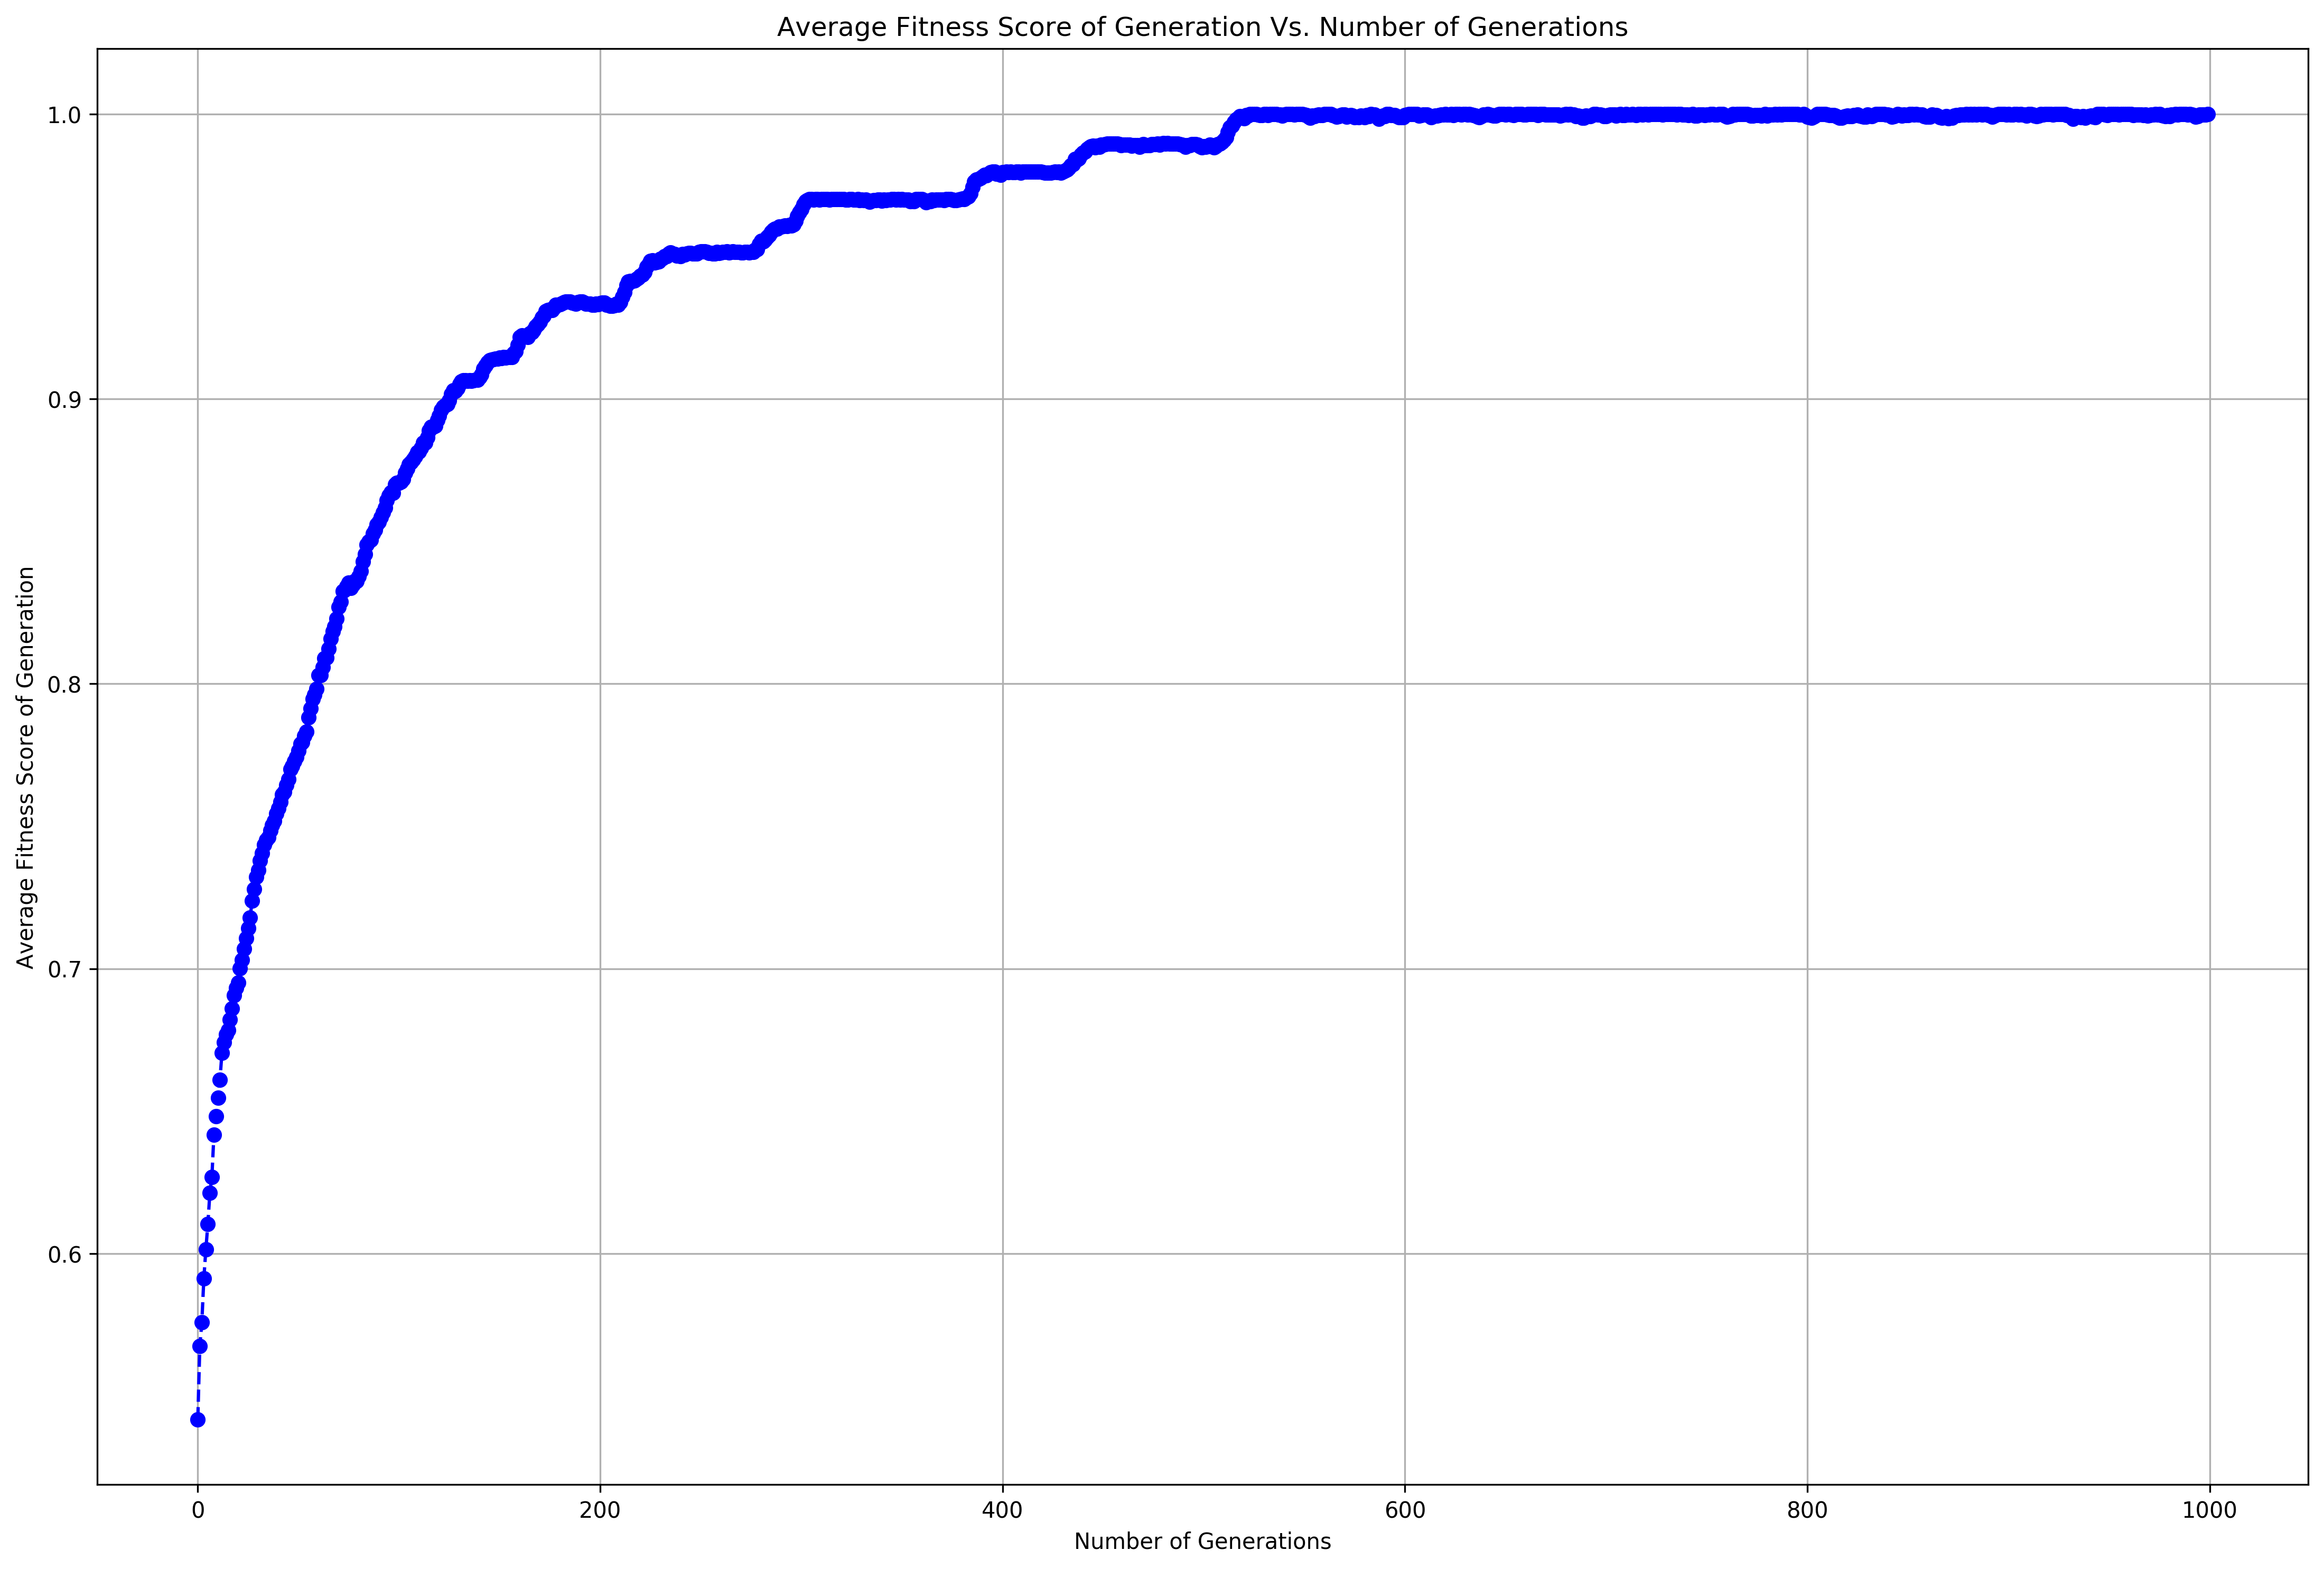

In [28]:
fig, ax = plt.subplots(1, 1)

ax.plot(*list(zip(*avg_fitness_scores)), linestyle='--', marker='o', color='b')
ax.set_xlabel('Number of Generations');
ax.set_ylabel('Average Fitness Score of Generation');
ax.set_title('Average Fitness Score of Generation Vs. Number of Generations')
ax.grid()

plt.show();

---
## Covariance Matrix Adaptation - ES<a id='cma-es'></a>


---
## Particle Swarm Optimization 

---
### Resources:
- [Convert binary to ASCII and vice versa](https://stackoverflow.com/questions/7396849/convert-binary-to-ascii-and-vice-versa)
- [Evolution of a salesman: A complete genetic algorithm tutorial for Python](https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35)
- [Evolutionary Algorithms Wiki](https://en.wikipedia.org/wiki/Evolutionary_algorithm)
- [Selection methods for creating mating pool Wiki](https://en.wikipedia.org/wiki/Selection_(genetic_algorithm))
    - [Fitness Proportionate](https://en.wikipedia.org/wiki/Fitness_proportionate_selection#Pseudocode)
    - [Tournament](https://en.wikipedia.org/wiki/Tournament_selection)
    - [Truncation](https://en.wikipedia.org/wiki/Truncation_selection)
    - [Stochastic universal sampling](https://en.wikipedia.org/wiki/Stochastic_universal_sampling)
- [Choosing fittest individuals to breed kill diversity](https://stackoverflow.com/questions/5173962/breeding-parents-for-multiple-children-in-genetic-algorithm)